# AMAL // Réseaux récurrents
                        notebook n°1 sur 3

Un RNN (Recurrent Neural Network) est une structure de Deep Learning. Chacune de ses couches travaille à partir d'un élément *distinct* d'un input *séquentiel*, mais le lit en fonction d'un état caché qui est prédit par la précédente. On peut ainsi prendre en compte une évolution de l'input au cours du temps, ce qui est par exemple légitime pour un texte ou pour de la musique.

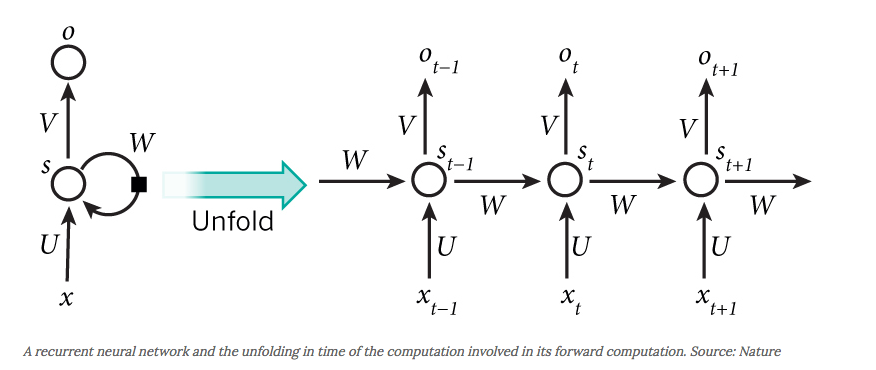

Les RNN se rendent utiles pour des tâches de classification, de complétion et de génération de séquences.

https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/

In [46]:
# //////////////////////////////////////////////////////////////////////////////////////////////// <useful libraries> ////

# Ne pas oublier d'executer dans le shell avant de lancer python :
# source /users/Enseignants/piwowarski/venv/amal/3.7/bin/activate

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
from tqdm.auto import tqdm

from torch.distributions import Categorical

# /////////////////////////////////////////////////////////////////////////////////////////////// </useful libraries> ////

In [2]:
# //////////////////////////////////////////////////////////////////////////////////////////////// <basic configuration> ////

import logging
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(level=logging.INFO)

# /////////////////////////////////////////////////////////////////////////////////////////////// </basic configuration> ////

### Table des matières

<a href="#clss">Codage de la classe RNN</a>  
<a href="#city">Classification de températures</a>  
&nbsp;&nbsp;Préparation des données // Lancement // Analyse des résultats  
<a href="#comp">Complétion de séquences</a>  
&nbsp;&nbsp;Lancement sur toutes les villes // Lancement ville par ville // Analyse des résultats  
<a href="#gnrt">Génération de séquences</a>  
&nbsp;&nbsp;Préparation des données // Entraînement // Analyse des résultats  

### Codage de la classe RNN  <a id='clss'></a>

Le modèle se trouve dans le fichier `tme4rnn.py`.  
Comme précédemment, on fait en sorte que les modèles appris puissent être récupérés en cas de pépin en codant également une classe `State`.

In [3]:
from tme4rnn import *

### Classification de températures  <a id='city'></a>

Le premier exercice consiste à retrouver la ville des Etats-Unis qui a été à l'origine d'une séquence de températures.  

#### Préparation des données

Nous avons accès à des mesures effectuées sur 30 villes étatsuniennes (on en retient 10). Les fonctions du fichier `tme4citydataset.py` servent à récupérer ces données et à en extraire des ensembles de séquences adaptés pour le *train* et le *test*.  

In [4]:
from tme4citydataset import *

#### Lancement

Le RNN va être entraîné sur 10 000 séquences étiquetées (avec recouvrements) issues des 10 villes et sera testé sur la totalité des séquences extraites de l'ensemble de test.  
Le paramètre variable ici sera la longueur des séquences utilisées pour la prédiction. On étudiera son impact sur la qualité de la classification.

In [10]:
# /////////////////////////////////////////////////////////////////////// <classifying cities through their weather> ////

writer = SummaryWriter("runs")

# Hyperparameters
latent = 10
epsilon = 0.001

# Trying various sequence lengths
for lenseq in [10,50,100,200]:
    
    print("\n//////////////////////////////////// Trying "+str(lenseq)+" as sequence length ////////////////////////////////////\n")
    
    # Building the train and test sets, feeding the DataLoaders
    trainX,trainY,testX,testY,mean,std = makeSets(lenseq,1,traincontent=10000)
    sbatch = 64
    traintemp = DataLoader(handleWeather(trainX,trainY),shuffle=True,batch_size=sbatch,drop_last=True)
    testtemp = DataLoader(handleWeather(testX,testY),shuffle=True,batch_size=sbatch,drop_last=True)
    
    # How many cities are there in the labels set ?
    dimout = int(torch.max(trainY)-torch.min(trainY)+1)

    # Creating a checkpointed model for each lenseq
    savepath = Path("classif"+str(lenseq)+".pch")
    if savepath.is_file():
        print("Restarting from previous state.")
        with savepath.open( "rb" ) as fp :
            state = torch.load(fp)
    else:
        rnn = RNN(1,latent,dimout).float()
        rnn = rnn.to(device)
        cel = nn.CrossEntropyLoss()
        optim = torch.optim.Adam(params=rnn.parameters(), lr=epsilon)
        state = State(rnn,optim)

    # Training the model
    for epoch in tqdm(range(state.epoch,101)):
        # We will compute an average loss over each epoch.
        losstrain = 0
        accytrain = 0
        divtrain = 0
        for x,y in traintemp:
            state.optim.zero_grad()
            x = x.t().to(device)
            y = y.long().to(device)
            # initial state
            h = torch.zeros(sbatch,latent,requires_grad=True).float().to(device)
            # forward
            ht = state.model(x,h)
            # decoding the last state to get a class prediction
            uncode = state.model.decode(ht[-1]).to(device)
            # loss & backprop
            acctr = sum((uncode.argmax(1) == y.reshape(-1))).item() / y.shape[0] 
            ltrain = cel(uncode,y) 
            ltrain.backward()
            state.optim.step()
            state.iteration += 1
            losstrain += ltrain
            accytrain += acctr
            divtrain += 1
        
        # Keeping track of the stats
        if epoch%10==0:
            print(f"Iterations|\t TRAIN {epoch}: current loss {losstrain/divtrain}, current accuracy {accytrain/divtrain}")
        
        losstest = 0
        accytest = 0
        divtest = 0
        # Testing the current parameters
        for x,y in testtemp:
            with torch.no_grad():
                x = x.t().to(device)
                y = y.long().to(device)
                h = torch.zeros(sbatch,latent,requires_grad=True).float().to(device)
                ht = state.model(x,h)
                uncode = state.model.decode(ht[-1]).to(device)
                ltest = cel(uncode,y) 
                accts = sum((uncode.argmax(1) == y.reshape(-1))).item() / y.shape[0] 
            losstest += ltest
            accytest += accts
            divtest += 1
        
        # Showing the test loss on the very last epoch
        if epoch==100:
            print(f"\nIterations|\t TEST {epoch}: final loss {losstest/divtest}, final accuracy {accytest/divtest}")
         
        # For each epoch, save the current losses and accuracies
        writer.add_scalars('Loss/RNNClassif/'+str(lenseq),{'train':losstrain/divtrain,'test':losstest/divtest}, epoch)
        writer.add_scalars('Accuracy/RNNClassif/'+str(lenseq),{'train':acctr,'test':accts}, epoch)
        # and the current state of the model
        with savepath.open ("wb") as fp:
            state.epoch = epoch+1
            torch.save(state, fp)
                      
    
    print("\033[92mDone.\033[0m\n")

writer.flush()
writer.close()

# ////////////////////////////////////////////////////////////////////// </classifying cities through their weather> ////


//////////////////////////////////// Trying 10 as sequence length ////////////////////////////////////



Iterations|	 TRAIN 0: current loss 2.2882370948791504, current accuracy 0.12970753205128205
Iterations|	 TRAIN 10: current loss 2.210437297821045, current accuracy 0.14983974358974358
Iterations|	 TRAIN 20: current loss 2.2048654556274414, current accuracy 0.15474759615384615
Iterations|	 TRAIN 30: current loss 2.2021644115448, current accuracy 0.15534855769230768
Iterations|	 TRAIN 40: current loss 2.1998791694641113, current accuracy 0.15494791666666666
Iterations|	 TRAIN 50: current loss 2.1988584995269775, current accuracy 0.1557491987179487
Iterations|	 TRAIN 60: current loss 2.1975760459899902, current accuracy 0.1544471153846154
Iterations|	 TRAIN 70: current loss 2.1976356506347656, current accuracy 0.15384615384615385
Iterations|	 TRAIN 80: current loss 2.1963768005371094, current accuracy 0.15424679487179488
Iterations|	 TRAIN 90: current loss 2.1951639652252197, current accuracy 0.15635016025641027
Iterations|	 TRAIN 100: current loss 2.1954193115234375, current accuracy 0.1

Iterations|	 TRAIN 0: current loss 2.264660120010376, current accuracy 0.12800480769230768
Iterations|	 TRAIN 10: current loss 2.2054712772369385, current accuracy 0.15014022435897437
Iterations|	 TRAIN 20: current loss 2.1993844509124756, current accuracy 0.14873798076923078
Iterations|	 TRAIN 30: current loss 2.1877427101135254, current accuracy 0.16095753205128205
Iterations|	 TRAIN 40: current loss 2.187462329864502, current accuracy 0.15564903846153846
Iterations|	 TRAIN 50: current loss 2.1919519901275635, current accuracy 0.1583533653846154
Iterations|	 TRAIN 60: current loss 2.1859638690948486, current accuracy 0.15765224358974358
Iterations|	 TRAIN 70: current loss 2.2066330909729004, current accuracy 0.15244391025641027
Iterations|	 TRAIN 80: current loss 2.199357032775879, current accuracy 0.1560496794871795
Iterations|	 TRAIN 90: current loss 2.1938540935516357, current accuracy 0.1505408653846154
Iterations|	 TRAIN 100: current loss 2.1906657218933105, current accuracy 0.1

Iterations|	 TRAIN 0: current loss 2.2721352577209473, current accuracy 0.14262820512820512
Iterations|	 TRAIN 10: current loss 2.1982758045196533, current accuracy 0.15134214743589744
Iterations|	 TRAIN 20: current loss 2.189122438430786, current accuracy 0.15614983974358973
Iterations|	 TRAIN 30: current loss 2.198133707046509, current accuracy 0.15865384615384615
Iterations|	 TRAIN 40: current loss 2.186081647872925, current accuracy 0.16185897435897437
Iterations|	 TRAIN 50: current loss 2.1753172874450684, current accuracy 0.1603565705128205
Iterations|	 TRAIN 60: current loss 2.1774396896362305, current accuracy 0.16296073717948717
Iterations|	 TRAIN 70: current loss 2.18224835395813, current accuracy 0.15745192307692307
Iterations|	 TRAIN 80: current loss 2.178654909133911, current accuracy 0.16045673076923078
Iterations|	 TRAIN 90: current loss 2.183255195617676, current accuracy 0.15895432692307693
Iterations|	 TRAIN 100: current loss 2.181375741958618, current accuracy 0.1607

Iterations|	 TRAIN 0: current loss 2.2849793434143066, current accuracy 0.12309695512820513
Iterations|	 TRAIN 10: current loss 2.2066242694854736, current accuracy 0.14813701923076922
Iterations|	 TRAIN 20: current loss 2.1844778060913086, current accuracy 0.15234375
Iterations|	 TRAIN 30: current loss 2.1791107654571533, current accuracy 0.15294471153846154
Iterations|	 TRAIN 40: current loss 2.18149995803833, current accuracy 0.15635016025641027
Iterations|	 TRAIN 50: current loss 2.178884267807007, current accuracy 0.1541466346153846
Iterations|	 TRAIN 60: current loss 2.192650079727173, current accuracy 0.15795272435897437
Iterations|	 TRAIN 70: current loss 2.1783084869384766, current accuracy 0.15334535256410256
Iterations|	 TRAIN 80: current loss 2.178359031677246, current accuracy 0.15825320512820512
Iterations|	 TRAIN 90: current loss 2.1708614826202393, current accuracy 0.16155849358974358
Iterations|	 TRAIN 100: current loss 2.2016172409057617, current accuracy 0.1589543269

#### Analyse des résultats

*(développer la cellule plus haut pour plus de données chiffrées)*  
**Ici, l'apprentissage n'est pas spectaculaire. Même après plusieurs epochs, il y a toujours des batchs sur lesquels le modèle performe mieux, et d'autres sur lesquels il ne réussit absolument pas. Le score sur un batch n'est donc pas représentatif ; on surveille la loss moyenne par epoch.**  
Ci-dessous, les graphiques associés pour des longueurs de séquences différentes (10, 50, 100 et 200), un pas d'apprentissage fixe à 10e-3, et une taille de couche cachée fixe à 15 neurones.

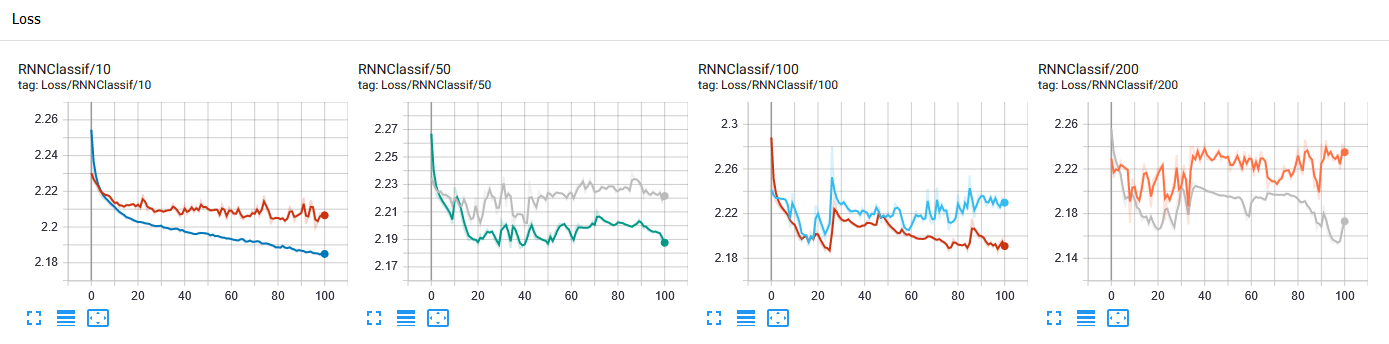

On constate 
- une instabilité extrême qui n'est pas compensée par des progrès dans l'apprentissage. Le modèle est en fait incapable de faire diminuer sa loss, qui stagne aux alentours de 2.2. Beaucoup d'autres paramétrages ont été essayés et n'ont pas été plus concluants.
- qu'augmenter la taille des séquences d'apprentissage n'aide pas le modèle. Cela ne fait que le perdre entre les données des différentes villes possibles. Un échantillon court (10 samples) est apparemment le plus simple à traiter et à reconnaître sans perte d'information.
- que les epochs à partir de la 20ème sont superflues et ne mènent qu'à du surapprentissage : sur les graphiques 2, 3 et 4, la loss en test remonte, la loss en train continue à diminuer.


**Pour montrer l'instabilité extrême des scores, on a créé séparément des courbes d'accuracy (valeurs calculées batch par batch cette fois).**  
Sous les mêmes paramétrages que précédemment, elles montrent que les scores oscillent entre 10% et 25%.

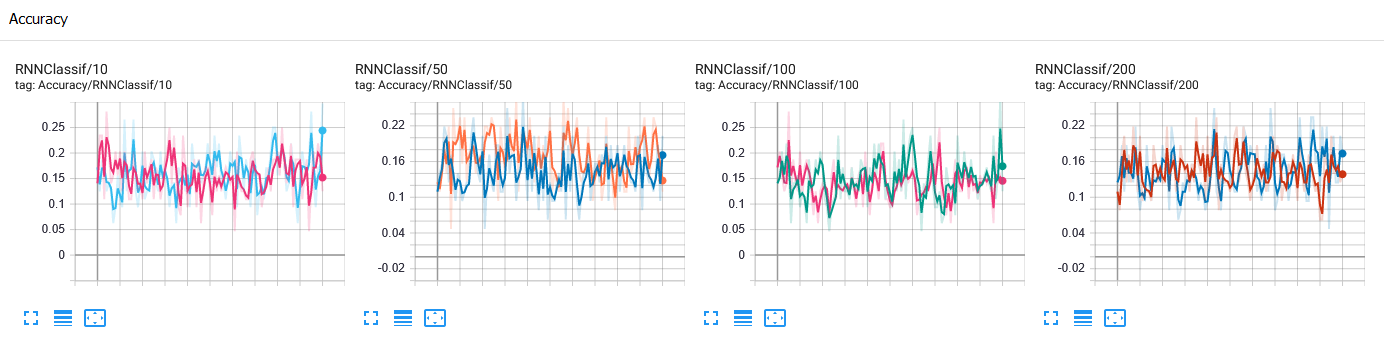 

Le modèle est donc légèrement meilleur que le random (avec dix villes, on s'attend à 10%), mais pas beaucoup plus ;  
et il n'est pas intelligent d'augmenter la taille des séquences, car cela n'influe pas positivement sur la précision moyenne en test.  
En se référant aux prints de la cellule ci-dessus, on a 13.5% en fin d'entraînement pour lenseq = 200, contre 15.5% pour lenseq = 10.

**Conclusion : le modèle RNN n'est pas performant sur cette tâche de classification. Cela est probablement dû à l'absence de mémoire à long terme : en traitant la fin d'une longue séquence, le modèle a plus ou moins oublié ce qu'il avait vu dans les premières parties de l'input. On reparlera de ce problème plus loin.**

Une autre raison est que les villes des Etats-Unis (on a retenu San Antonio, Dallas, Houston, Kansas City, Minneapolis, Saint Louis, Chicago, Nashville, Indianapolis, Atlanta) peuvent avoir des climats similaires.

### Complétion de séquences <a id='comp'></a>

Sur les mêmes données, on se propose maintenant de prédire la suite d'une série de températures dans une ville donnée.  
L'input est donc toujours multiple (une séquence) mais l'output l'est aussi : il ne s'agit plus d'une prédiction de classe. Il est sémantiquement de la même nature que les données d'entrée. On parle d'architecture many-to-many.

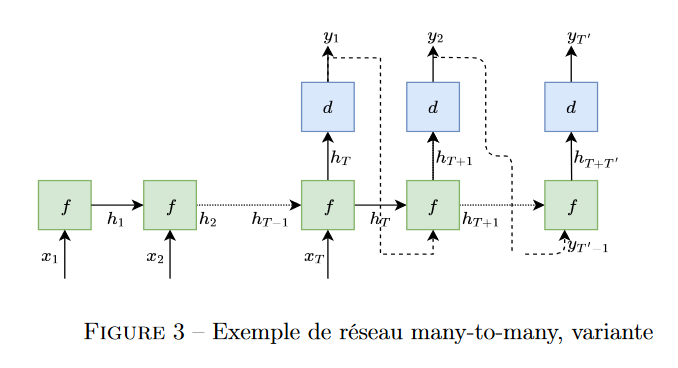

Voyons si le même RNN sait présenter la météo. On essaie d'abord de l'entraîner sur toutes les villes ; on essaie aussi sur chacune séparément pour voir si cela le rend plus capable d'en saisir les spécificités.
Dans les deux cas, la longueur de séquence conservée pour l'entraînement est 100.

#### Lancement et apprentissage sur toutes les villes 

In [59]:
# ///////////////////////////////////////////////////////////////////////////////////// <weather sequence completion> ////

writer = SummaryWriter("runs")

# Hyperparameters
latent = 10
epsilon = 0.001

# Trying various horizons : how far ahead would you like to forecast ?
for horizon in [2,3,15,50]:
    print("\n//////////////////////////////////// Trying "+str(horizon)+" as prediction length ///////////////////////////////////////\n")
    
    # Making the train and test sets, feeding the DataLoaders
    trainX,trainY,testX,testY = makeSets(100,5)
    sbatch = 64
    traintemp = DataLoader(handleWeather(trainX,trainY),shuffle=True,batch_size=sbatch,drop_last=True)
    testtemp = DataLoader(handleWeather(testX,testY),shuffle=True,batch_size=sbatch,drop_last=True)

    # Creating a checkpointed model for each lenseq
    savepath = Path("complete"+str(horizon)+".pch")
    if savepath.is_file():
        print("Restarting from previous state.")
        with savepath.open( "rb" ) as fp :
            state = torch.load(fp)
    else:
        rnn = RNN(1,latent,1).float()
        rnn = rnn.to(device)
        mse = nn.MSELoss()
        optim = torch.optim.Adam(params=rnn.parameters(),lr=epsilon)
        state = State(rnn,optim)
        
    # Training the model
    for epoch in tqdm(range(state.epoch,21)):
        for x,_ in traintemp:
            x = x.t().to(device)
            state.optim.zero_grad()

            preds = []
            # Phase 1 : get to the last known digit of the sequence and make a prediction
            h = torch.zeros(sbatch,latent,requires_grad=True).float().to(device)
            ht = state.model(x[:-horizon],h)[-1]
            nextval = state.model.decode(ht)
            preds.append(nextval)
            
            # Phase 2 : hide the rest of the sequence,
            # and keep on building predictions based on what the model already outputted
            for t in range(1,horizon):
                ht = state.model.oneStep(nextval,ht)
                nextval = state.model.decode(ht)
                preds.append(nextval)
            preds = torch.stack(preds).squeeze()
            
            # Compute the loss over the whole predicted sequence
            ltrain = mse(preds,x[-horizon:])
            ltrain.backward()
            state.optim.step()
            state.iteration += 1
            
        if epoch%10==0:
            print(f"Iterations|\t TRAIN {epoch}: loss {ltrain}")
            # Printing forecasted samples
            showorig = x[-1,1].item()
            showgenr = preds[-1,1].item()
            print("\033[92m"+str(showorig)+"\033[0m")
            print(str(showgenr))

        # Testing current parameters
        for x,_ in testtemp:
            with torch.no_grad():
                x = x.t().to(device)
                h = torch.zeros(sbatch,latent,requires_grad=True).float().to(device)
                ht = state.model(x[:-horizon],h)[-1]
                preds = []
                nextval = state.model.decode(ht)
                preds.append(nextval)
                for t in range(1,horizon):
                    ht = state.model.oneStep(nextval,ht)
                    nextval = state.model.decode(ht)
                    preds.append(nextval)
                preds = torch.stack(preds).squeeze()
                ltest = mse(preds[-1],x[-1])  

        # Saving the losses
        writer.add_scalars('Loss/RNNComplete/'+str(horizon),{'train':ltrain,'test':ltest}, epoch)
        # Saving the current state after each epoch
        with savepath.open ("wb") as fp:
            state.epoch = epoch+1
            torch.save(state, fp)

    print("\033[92mDone.\033[0m\n")

# //////////////////////////////////////////////////////////////////////////////////// </weather sequence completion> ////


//////////////////////////////////// Trying 2 as prediction length ///////////////////////////////////////



Iterations|	 TRAIN 0: loss 0.14844480156898499
1.6908972263336182
1.0399094820022583
Iterations|	 TRAIN 10: loss 0.020906681194901466
-0.05089449882507324
-0.06553012132644653
Iterations|	 TRAIN 20: loss 0.01821410097181797
-2.7228801250457764
-2.697108507156372

Done.


//////////////////////////////////// Trying 3 as prediction length ///////////////////////////////////////



Iterations|	 TRAIN 0: loss 0.1736636608839035
0.2633030116558075
0.35703665018081665
Iterations|	 TRAIN 10: loss 0.015889666974544525
0.5929474234580994
0.5324690937995911
Iterations|	 TRAIN 20: loss 0.062258850783109665
1.3867864608764648
1.343433141708374

Done.


//////////////////////////////////// Trying 15 as prediction length ///////////////////////////////////////



Iterations|	 TRAIN 0: loss 0.38240712881088257
-0.047749895602464676
0.6248806715011597
Iterations|	 TRAIN 10: loss 0.21410799026489258
-1.2370202541351318
-1.2543545961380005
Iterations|	 TRAIN 20: loss 0.17950661480426788
1.465219259262085
0.797221302986145

Done.


//////////////////////////////////// Trying 50 as prediction length ///////////////////////////////////////



Iterations|	 TRAIN 0: loss 0.693024754524231
0.6948439478874207
0.7063313722610474
Iterations|	 TRAIN 10: loss 0.5727105736732483
0.26472213864326477
1.008549451828003
Iterations|	 TRAIN 20: loss 0.4521212875843048
1.6714824438095093
0.8556761741638184

Done.



#### Lancement et apprentissage ville par ville

In [67]:
# //////////////////////////////////////////////////////////////////////////////////// <weather sequence completion> ////

writer = SummaryWriter("runs")

latent = 10
epsilon = 0.001

# Trying various horizons
for horizon in [2,3,15,50]:
    print("\n//////////////////////////////////// Trying "+str(horizon)+" as prediction length ///////////////////////////////////////\n")
    
    for i in range(10,20):
        # Making the train and test sets, feeding the DataLoaders
        trainX,trainY,testX,testY = makeSets(100,2,i)
        sbatch = 64
        traintemp = DataLoader(handleWeather(trainX,trainY),shuffle=True,batch_size=sbatch,drop_last=True)
        testtemp = DataLoader(handleWeather(testX,testY),shuffle=True,batch_size=sbatch,drop_last=True)

        # Creating a checkpointed model for each horizon length
        savepath = Path("completesingle"+str(horizon)+'_'+str(i)+".pch")
        if savepath.is_file():
            print("Restarting from previous state.")
            with savepath.open( "rb" ) as fp :
                state = torch.load(fp)
        else:
            rnn = RNN(1,latent,1).float()
            rnn = rnn.to(device)
            mse = nn.MSELoss()
            optim = torch.optim.Adam(params=rnn.parameters(),lr=epsilon)
            state = State(rnn,optim)

        # Training the model
        for epoch in tqdm(range(state.epoch,21)):
            for x,_ in traintemp:
                state.optim.zero_grad()
                x = x.t().to(device)
                
                preds = []
                # Phase 1 : get to the last known digit of the sequence and make a prediction
                h = torch.zeros(sbatch,latent,requires_grad=True).float().to(device)
                ht = state.model(x[:-horizon],h)[-1]
                nextval = state.model.decode(ht)
                preds.append(nextval)

                # Phase 2 : hide the rest of the sequence,
                # and keep on building predictions based on what the model already predicted
                for t in range(1,horizon):
                    ht = state.model.oneStep(nextval,ht)
                    nextval = state.model.decode(ht)
                    preds.append(nextval)
                preds = torch.stack(preds).squeeze()

                # Compute the loss over the whole predicted sequence
                ltrain = mse(preds,x[-horizon:])
                ltrain.backward()
                state.optim.step()
                state.iteration += 1

            if epoch%10==0:
                print(f"Iterations|\t TRAIN {epoch}: loss {ltrain}")
                # Printing forecasted samples
                showorig = x[-1,1].item()
                showgenr = preds[-1,1].item()
                print("\033[92m"+str(showorig)+"\033[0m")
                print(str(showgenr))

            # Testing current parameters
            for x,_ in testtemp:
                with torch.no_grad():
                    x = x.t().to(device)
                    preds = []
                    h = torch.zeros(sbatch,latent,requires_grad=True).float().to(device)
                    ht = state.model(x[:-horizon],h)[-1]
                    nextval = state.model.decode(ht)
                    preds.append(nextval)
                    for t in range(1,horizon):
                        ht = state.model.oneStep(nextval,ht)
                        nextval = state.model.decode(ht)
                        preds.append(nextval)
                    preds = torch.stack(preds).squeeze()
                    ltest = mse(preds[-1],x[-1])  

            # Saving the losses
            writer.add_scalars('Loss/RNNCompleteSingle'+str(i)+'/'+str(horizon),{'train':ltrain,'test':ltest}, epoch)
            # Saving the current state after each epoch
            with savepath.open ("wb") as fp:
                state.epoch = epoch+1
                torch.save(state, fp)
                
        print("Done with city n°",i,"\n")

    print("\033[92mDone.\033[0m\n")

# /////////////////////////////////////////////////////////////////////////////////// </weather sequence completion> ////


//////////////////////////////////// Trying 2 as prediction length ///////////////////////////////////////



Iterations|	 TRAIN 0: loss 0.17702388763427734
0.9773626327514648
1.009670376777649
Iterations|	 TRAIN 10: loss 0.04935551434755325
-1.1508938074111938
-1.5415288209915161
Iterations|	 TRAIN 20: loss 0.027378637343645096
-1.5405105352401733
-1.2719502449035645

Done with city n° 10 



Iterations|	 TRAIN 0: loss 0.08340851962566376
-0.28539684414863586
-0.7982822060585022
Iterations|	 TRAIN 10: loss 0.05233060568571091
-0.06744471192359924
0.061676397919654846
Iterations|	 TRAIN 20: loss 0.0258171409368515
-1.411739706993103
-1.3261327743530273

Done with city n° 11 



Iterations|	 TRAIN 0: loss 0.13542334735393524
-0.8297573328018188
-0.6457765102386475
Iterations|	 TRAIN 10: loss 0.026711104437708855
-0.14426583051681519
-0.18874964118003845
Iterations|	 TRAIN 20: loss 0.04415048658847809
-0.628738284111023
-0.6427433490753174

Done with city n° 12 



Iterations|	 TRAIN 0: loss 0.08066031336784363
-1.2229399681091309
-1.0663560628890991
Iterations|	 TRAIN 10: loss 0.012370430864393711
-0.8687574863433838
-0.7845478653907776
Iterations|	 TRAIN 20: loss 0.02222020924091339
-0.3331000506877899
-0.4513077139854431

Done with city n° 13 



Iterations|	 TRAIN 0: loss 0.08845160156488419
-0.14871065318584442
-0.05623108148574829
Iterations|	 TRAIN 10: loss 0.010945864021778107
-0.3779648244380951
-0.30487439036369324
Iterations|	 TRAIN 20: loss 0.007068954408168793
1.0541088581085205
0.9487109184265137

Done with city n° 14 



Iterations|	 TRAIN 0: loss 0.3059615194797516
0.4406810402870178
0.6951804757118225
Iterations|	 TRAIN 10: loss 0.025239204987883568
0.41513943672180176
0.5573093891143799
Iterations|	 TRAIN 20: loss 0.017535103484988213
1.3339661359786987
1.3262264728546143

Done with city n° 15 



Iterations|	 TRAIN 0: loss 0.11682400107383728
-0.2725777328014374
-0.36555784940719604
Iterations|	 TRAIN 10: loss 0.015935789793729782
0.9992825984954834
0.960206151008606
Iterations|	 TRAIN 20: loss 0.008209232240915298
-0.6922187805175781
-0.6241445541381836

Done with city n° 16 



Iterations|	 TRAIN 0: loss 0.0876024141907692
0.21385622024536133
0.345528781414032
Iterations|	 TRAIN 10: loss 0.025434585288167
-1.9110510349273682
-1.771921992301941
Iterations|	 TRAIN 20: loss 0.022660546004772186
-1.4245235919952393
-1.3569064140319824

Done with city n° 17 



Iterations|	 TRAIN 0: loss 0.08075524121522903
0.9116687178611755
0.9136002063751221
Iterations|	 TRAIN 10: loss 0.08015254139900208
0.625227689743042
0.9859698414802551
Iterations|	 TRAIN 20: loss 0.023925472050905228
1.4402189254760742
1.3310437202453613

Done with city n° 18 



Iterations|	 TRAIN 0: loss 0.07097171992063522
-0.24228817224502563
-0.31012657284736633
Iterations|	 TRAIN 10: loss 0.11494303494691849
-0.8788663744926453
-0.9920098185539246
Iterations|	 TRAIN 20: loss 0.02893988974392414
0.5736915469169617
0.5233786106109619

Done with city n° 19 

Done.


//////////////////////////////////// Trying 3 as prediction length ///////////////////////////////////////



Iterations|	 TRAIN 0: loss 0.12245258688926697
1.539348840713501
0.8552340269088745
Iterations|	 TRAIN 10: loss 0.039156027138233185
0.1205635741353035
0.0032674819231033325
Iterations|	 TRAIN 20: loss 0.03691093623638153
1.330504298210144
1.3688666820526123

Done with city n° 10 



Iterations|	 TRAIN 0: loss 0.15955734252929688
0.49274536967277527
0.7198694348335266
Iterations|	 TRAIN 10: loss 0.04332519695162773
0.15221260488033295
-0.6293178796768188
Iterations|	 TRAIN 20: loss 0.039655689150094986
-1.2260912656784058
-1.7453255653381348

Done with city n° 11 



Iterations|	 TRAIN 0: loss 0.17479483783245087
0.6529319882392883
0.8506916761398315
Iterations|	 TRAIN 10: loss 0.039442162960767746
-2.3474884033203125
-2.136011838912964
Iterations|	 TRAIN 20: loss 0.03688853234052658
1.7499947547912598
1.5037126541137695

Done with city n° 12 



Iterations|	 TRAIN 0: loss 0.1872476488351822
-0.4071212708950043
-0.9493123292922974
Iterations|	 TRAIN 10: loss 0.024393968284130096
0.848028302192688
0.8600668907165527
Iterations|	 TRAIN 20: loss 0.02377244643867016
1.2988048791885376
1.011497974395752

Done with city n° 13 



Iterations|	 TRAIN 0: loss 0.3298512399196625
0.9209297299385071
0.3738637864589691
Iterations|	 TRAIN 10: loss 0.01687903143465519
-0.2064162790775299
-0.4179004728794098
Iterations|	 TRAIN 20: loss 0.012094900943338871
-0.7044349312782288
-0.4831865727901459

Done with city n° 14 



Iterations|	 TRAIN 0: loss 0.22211994230747223
-0.5250542163848877
-0.5940151214599609
Iterations|	 TRAIN 10: loss 0.03504014015197754
-0.310237854719162
0.002597913146018982
Iterations|	 TRAIN 20: loss 0.027950063347816467
0.5580106973648071
0.5854153633117676

Done with city n° 15 



Iterations|	 TRAIN 0: loss 0.1965113878250122
1.647273063659668
0.924603283405304
Iterations|	 TRAIN 10: loss 0.0280288252979517
-1.360066294670105
-1.3238835334777832
Iterations|	 TRAIN 20: loss 0.015939390286803246
-0.2642674446105957
-0.3548070192337036

Done with city n° 16 



Iterations|	 TRAIN 0: loss 0.18678128719329834
0.6291236281394958
1.0318024158477783
Iterations|	 TRAIN 10: loss 0.034918222576379776
0.9426393508911133
1.2207591533660889
Iterations|	 TRAIN 20: loss 0.0238140020519495
0.8890656232833862
1.1415599584579468

Done with city n° 17 



Iterations|	 TRAIN 0: loss 0.12332601100206375
0.6499698162078857
0.9637152552604675
Iterations|	 TRAIN 10: loss 0.03843945637345314
-1.094300389289856
-1.5105968713760376
Iterations|	 TRAIN 20: loss 0.017545079812407494
-0.20232287049293518
-0.03217574954032898

Done with city n° 18 



Iterations|	 TRAIN 0: loss 0.25654923915863037
0.7964399456977844
0.7422313690185547
Iterations|	 TRAIN 10: loss 0.03926321119070053
1.2674099206924438
0.9749098420143127
Iterations|	 TRAIN 20: loss 0.0264249499887228
-1.2672789096832275
-1.2206313610076904

Done with city n° 19 

Done.


//////////////////////////////////// Trying 15 as prediction length ///////////////////////////////////////



Iterations|	 TRAIN 0: loss 0.4550085663795471
1.0695676803588867
0.6732180118560791
Iterations|	 TRAIN 10: loss 0.2651052176952362
0.23622295260429382
-0.488577663898468
Iterations|	 TRAIN 20: loss 0.17284820973873138
1.7581355571746826
1.515799641609192

Done with city n° 10 



Iterations|	 TRAIN 0: loss 0.46566516160964966
0.8337985277175903
-0.5147305130958557
Iterations|	 TRAIN 10: loss 0.33283349871635437
0.48409304022789
-0.17893964052200317
Iterations|	 TRAIN 20: loss 0.2855782210826874
-0.7993452548980713
-1.0345940589904785

Done with city n° 11 



Iterations|	 TRAIN 0: loss 0.49013927578926086
1.6069313287734985
0.7713091969490051
Iterations|	 TRAIN 10: loss 0.33112847805023193
-1.3590202331542969
-0.17672088742256165
Iterations|	 TRAIN 20: loss 0.3521580100059509
1.139319658279419
0.7620940804481506

Done with city n° 12 



Iterations|	 TRAIN 0: loss 0.34538528323173523
-0.7690309286117554
0.6776108145713806
Iterations|	 TRAIN 10: loss 0.2774010896682739
-0.5225626230239868
-1.00519859790802
Iterations|	 TRAIN 20: loss 0.27556112408638
0.46155720949172974
0.8310340642929077

Done with city n° 13 



Iterations|	 TRAIN 0: loss 0.2631782591342926
0.8984408974647522
0.8114947080612183
Iterations|	 TRAIN 10: loss 0.12352941930294037
1.3838396072387695
0.899993360042572
Iterations|	 TRAIN 20: loss 0.15136602520942688
0.9857810139656067
-0.03821307420730591

Done with city n° 14 



Iterations|	 TRAIN 0: loss 0.49111488461494446
1.4504529237747192
0.8041626811027527
Iterations|	 TRAIN 10: loss 0.2808988392353058
0.3142949342727661
-0.12584154307842255
Iterations|	 TRAIN 20: loss 0.18067219853401184
0.8885107636451721
0.24159663915634155

Done with city n° 15 



Iterations|	 TRAIN 0: loss 0.31179171800613403
0.9900752305984497
0.6934906840324402
Iterations|	 TRAIN 10: loss 0.23419532179832458
1.2457607984542847
1.1445767879486084
Iterations|	 TRAIN 20: loss 0.16896997392177582
1.6151843070983887
1.2017008066177368

Done with city n° 16 



Iterations|	 TRAIN 0: loss 0.42168936133384705
0.34946462512016296
0.7034032940864563
Iterations|	 TRAIN 10: loss 0.24681231379508972
-0.4677116870880127
-1.3701120615005493
Iterations|	 TRAIN 20: loss 0.1509525179862976
-1.4084633588790894
-1.0594311952590942

Done with city n° 17 



Iterations|	 TRAIN 0: loss 0.2990947961807251
-1.306155800819397
-0.9187886714935303
Iterations|	 TRAIN 10: loss 0.2072741836309433
-0.2114938199520111
-0.5135399699211121
Iterations|	 TRAIN 20: loss 0.12923400104045868
-0.26791420578956604
0.970472514629364

Done with city n° 18 



Iterations|	 TRAIN 0: loss 0.4312291145324707
1.3581734895706177
0.6930252313613892
Iterations|	 TRAIN 10: loss 0.3508443236351013
0.0258000660687685
-0.3937578797340393
Iterations|	 TRAIN 20: loss 0.1857096403837204
-1.130751371383667
-1.2572838068008423

Done with city n° 19 

Done.


//////////////////////////////////// Trying 50 as prediction length ///////////////////////////////////////



Iterations|	 TRAIN 0: loss 0.9387370347976685
0.8472452163696289
-0.030153430998325348
Iterations|	 TRAIN 10: loss 0.49792101979255676
-1.5557912588119507
-0.8897627592086792
Iterations|	 TRAIN 20: loss 0.6206035017967224
0.4624618589878082
0.4845212697982788

Done with city n° 10 



Iterations|	 TRAIN 0: loss 0.7900458574295044
0.17064163088798523
0.029515355825424194
Iterations|	 TRAIN 10: loss 0.5319702625274658
0.1538320779800415
-0.6033313274383545
Iterations|	 TRAIN 20: loss 0.5461336374282837
0.7333486080169678
0.7306159734725952

Done with city n° 11 



Iterations|	 TRAIN 0: loss 0.49101540446281433
-0.4076257050037384
0.49575793743133545
Iterations|	 TRAIN 10: loss 0.4203699231147766
0.581223726272583
0.8902473449707031
Iterations|	 TRAIN 20: loss 0.4092705249786377
-0.5730432868003845
-0.15917669236660004

Done with city n° 12 



Iterations|	 TRAIN 0: loss 0.5482845306396484
-1.4345812797546387
-0.7404687404632568
Iterations|	 TRAIN 10: loss 0.5452861785888672
-1.062811017036438
-0.7152510285377502
Iterations|	 TRAIN 20: loss 0.5507725477218628
-1.0145870447158813
-0.8135257959365845

Done with city n° 13 



Iterations|	 TRAIN 0: loss 0.44273239374160767
-0.9532634615898132
-0.4663785398006439
Iterations|	 TRAIN 10: loss 0.3978349566459656
0.8444610834121704
0.8564484715461731
Iterations|	 TRAIN 20: loss 0.20591217279434204
0.20472541451454163
-0.19061017036437988

Done with city n° 14 



Iterations|	 TRAIN 0: loss 0.49752742052078247
-2.04577898979187
-0.8553527593612671
Iterations|	 TRAIN 10: loss 0.5359477400779724
-1.6265872716903687
0.571321964263916
Iterations|	 TRAIN 20: loss 0.4249532222747803
0.5677030086517334
0.7232627272605896

Done with city n° 15 



Iterations|	 TRAIN 0: loss 1.0351885557174683
-0.2988286316394806
0.0051779597997665405
Iterations|	 TRAIN 10: loss 0.41156846284866333
1.3482738733291626
0.7126516103744507
Iterations|	 TRAIN 20: loss 0.4222659766674042
-0.868417501449585
-0.8216612339019775

Done with city n° 16 



Iterations|	 TRAIN 0: loss 1.0146006345748901
0.546053946018219
-0.0022645890712738037
Iterations|	 TRAIN 10: loss 0.4098392128944397
0.7987128496170044
-0.18925923109054565
Iterations|	 TRAIN 20: loss 0.3547743558883667
0.305138498544693
0.9227097630500793

Done with city n° 17 



Iterations|	 TRAIN 0: loss 0.9881188869476318
-2.1308352947235107
0.02840609848499298
Iterations|	 TRAIN 10: loss 0.33061522245407104
0.03945539891719818
-0.9841313362121582
Iterations|	 TRAIN 20: loss 0.3137941062450409
-0.15642978250980377
0.943288266658783

Done with city n° 18 



Iterations|	 TRAIN 0: loss 0.5153408646583557
1.996955156326294
0.7330272197723389
Iterations|	 TRAIN 10: loss 0.43919143080711365
-0.18103034794330597
-0.6728452444076538
Iterations|	 TRAIN 20: loss 0.43240830302238464
1.2041404247283936
0.6331931948661804

Done with city n° 19 

Done.



#### Analyse des résultats

Il n'est en fait pas plus intelligent d'utiliser le RNN sur des villes séparées. Les graphes montrent des signes de surapprentissage : la loss en test est toujours au-dessus de la loss en train. Un exemple sur la ville n°10 :

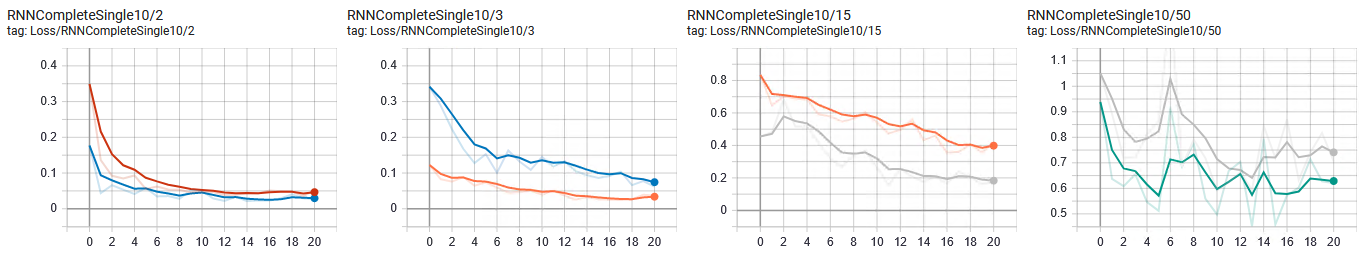

et sur la ville n°19 :
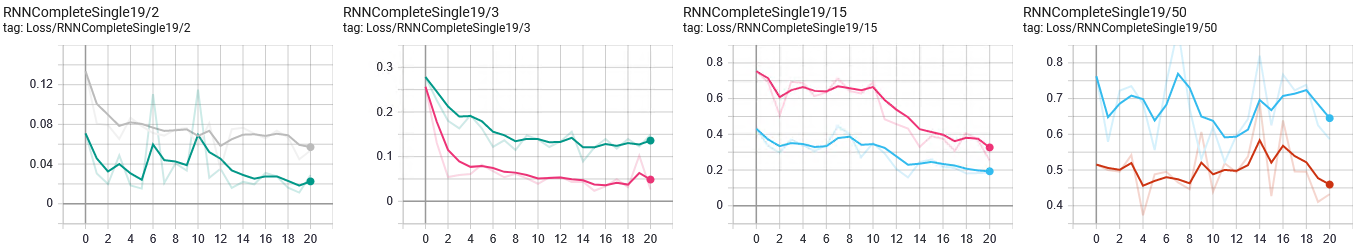

En revanche, lorsqu'il découvre leurs données ensemble, il surapprend un peu moins (bien comparer les axes par rapport aux graphes précédents). On aurait pu s'attendre à ce qu'il se trompe beaucoup plus lourdement étant donnée la "diversité" des villes ; or, pas du tout. La combination des villes dans un même ensemble d'apprentissage peut aider le modèle à régulariser ses paramètres, et cela compense le manque de spécificité dans cet apprentissage.

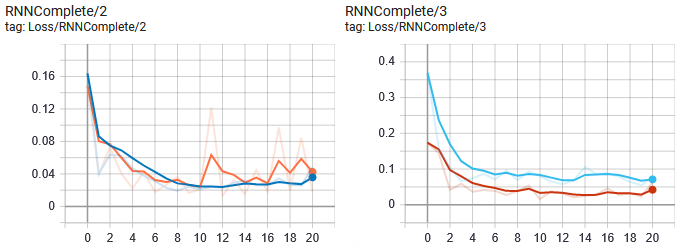

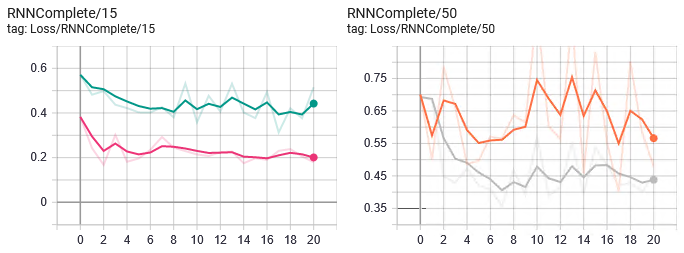

Dans les deux cas, devoir effectuer des prédictions à un horizon supérieur à deux ou trois pas de temps n'est absolument pas concluant, de nouveau en raison du manque de mémoire à long terme - le modèle aura juste tendance à réagir à la fin des séquences, et donc à se répéter.  
L'effet positif de la régularisation est lui aussi atténué par la distance de l'horizon : sincèrement, pas de différence visible entre les courbes pour les versions SingleCity vs. la complétion sur toutes les villes pour plus de 15 pas de temps. Toutes montrent de piètres performances.

### Génération de séquences <a id='gnrt'></a>

On change maintenant de paradigme en passant à du NLP. Les données concernées sont des discours de D. Trump. On aimerait générer un discours dans le style de l'orateur.

#### Préparation des données

In [11]:
from tme4trumpdataset import *

#### Apprentissage puis génération

In [49]:
# //////////////////////////////////////////////////////////////////////////////////////////////// <let's talk Trump> ////

writer = SummaryWriter("runs")

latent = int(len(lettre2id))   
epsilon = 0.0001

# Trying various sequence lengths
for lenseq in [15,42,70]:
    # Making the train set (no test set), feeding the DataLoader
    sbatch = 64
    print("\nGenerating the sequences...")
    trainspeech = DataLoader(handleSpeech(listen('./data/trump_full_speech.txt'),lenseq),shuffle=True,batch_size=sbatch,drop_last=True)

    print("\n/////////////////////////////// Trying "+str(lenseq)+" as original sequence length ////////////////////////////////\n")
    
    # Creating a checkpointed model for each length
    savepath = Path("generate"+str(lenseq)+".pch")
    if savepath.is_file():
        print("Restarting from previous state.")
        with savepath.open("rb") as fp :
            state = torch.load(fp)
    else:
        # step 1 : encoding the input
        linconv = nn.Linear(len(lettre2id),len(lettre2id)) 
        linconv = linconv.to(device)
        # step 2 : processing it
        rnn = RNN(len(lettre2id),latent,len(lettre2id)).float()
        rnn = rnn.to(device)
        cel = nn.CrossEntropyLoss()
        optim = torch.optim.Adam(params=rnn.parameters(),lr=epsilon)
        state = State(rnn,optim,linconv)
    
    # Training the model
    for epoch in tqdm(range(state.epoch,101)):
        
        for x,_ in trainspeech:
            state.optim.zero_grad()
            x = x.to(device)
            ltrain = 0
            # Converting the input to one-hot + linear encoding layer 
            hottie = nn.functional.one_hot(x.t().to(torch.int64),num_classes=len(lettre2id)).float().to(device)
            hottie = linconv(hottie)
            ht = torch.zeros(sbatch,latent,requires_grad=True).float().to(device)
            for t in range(0,len(x.t())-1):
                # Outputting an estimate of the hidden states for the known data
                ht = state.model.oneStep(hottie[t],ht)
                # Getting the associated prb. distribution over all the letters in the alphabet.
                distr = state.model.decode(ht)
                # The model will hopefully learn something close to the original sentence after a while.
                ltrain += cel(distr,x.t()[t+1].long())
            ltrain /= lenseq-1
            ltrain.backward()
            state.optim.step()
            state.iteration += 1

        writer.add_scalars('Loss/RNNGenerate/'+str(lenseq),{'train':ltrain},epoch)
        # Saving the current state after each epoch
        with savepath.open("wb") as fp:
            state.epoch = epoch+1
            torch.save(state,fp)

    print("Trying to generate new sentences")
    # ...of the same length   
    print("\n...from known init strings (argmax)\n")
    s = ["[appl", "Pr", ". ","nati","'re g","a lot o","we w","$","that's not f","I am","jo","Hillary C","Hi","Oba","It's","United ","'s","Tr"]
    for i in range(len(s)):
        x = string2code(s[i])
        hottie = nn.functional.one_hot(x.t().to(torch.int64),num_classes=len(lettre2id)).float().to(device)
        hottie = linconv(hottie)
        h = torch.zeros(1,latent,requires_grad=True).float().to(device)
        # Forwarding on the known part of the sentence
        ht = state.model(hottie,h)
        # Making a first prediction
        ht = ht[-1]
        distr = state.model.decode(ht)
        out = [distr.argmax(1)]  
        # Going on
        for t in range(lenseq):
            ht = state.model.oneStep(linconv(nn.functional.one_hot(out[-1],num_classes=len(lettre2id)).float()),ht)
            distr = state.model.decode(ht)
            out.append(distr.argmax(1))
        out = torch.stack(out).squeeze(1)
        init = [i.item() for i in x.t()]
        code = [c.item() for c in out]
        print(code2string(init)+"\033[92m"+code2string(code)+"\033[0m")
    
    print("\n...from empty strings (sampling from a predicted distribution)\n")
    for _ in range(10):
        ht = torch.zeros(1,latent,requires_grad=True).float().to(device)
        out = [torch.tensor([0]).to(device)]
        for t in range(lenseq):
            ht = state.model.oneStep(linconv(nn.functional.one_hot(out[-1],num_classes=len(lettre2id)).float()),ht)
            distr = Categorical(logits=state.model.decode(ht))
            out.append(distr.sample())
        out = torch.stack(out).squeeze(1)
        code = [c.item() for c in out]
        print("\033[91m"+code2string(code)+"\033[0m")
        
    print("\n\033[92mDone.\033[0m\n")

writer.flush()
writer.close()
        
# /////////////////////////////////////////////////////////////////////////////////////////////// </let's talk Trump> ////


Generating the sequences...

/////////////////////////////// Trying 15 as original sequence length ////////////////////////////////




Trying to generate new sentences

...from known init strings (argmax)

[applause] We will be
Press and the peop
. The world the pe
nation is a country 
're going to be a cou
a lot of the say the ma
we will be a country
$ States the many
that's not for the come in t
I am not the people 
jobs and the peopl
Hillary Clinton with the 
Hillary Clinton wi
Obady of the say th
It's a country the s
United States the many 
's the say the man
Trade and the peop

...from empty strings (sampling from a predicted distribution)

 Corverrayes, h
nging the messi
 Clintan, I'm e
 jobranga ge an
 brive make day
just haw tomen 
 who Badmen inc
 Bight Sercal I
 Clinton presse
 Cricanss penve

Done.


Generating the sequences...

/////////////////////////////// Trying 42 as original sequence length ////////////////////////////////




Trying to generate new sentences

...from known init strings (argmax)

[applause] And the will be a going to the said t
Prestions of the people the said the said the
. We are going to the said the said the said 
nation of the people the said the said the said
're going to the said the said the said the said
a lot of the people the said the said the said the
we will be a going to the said the said the sai
$ American and the said the said the said th
that's not for the said the said the said the said the 
I american live the said the said the said the 
jon our country and the said the said the sai
Hillary Clinton all of the said the said the said th
Hillary Clinton all of the said the said the 
Obama and we will be a going to the said the s
It's a the said the said the said the said the 
United States in the people the said the said the 
's going to the said the said the said the sa
Trang to be a going to the said the said the 

...from empty strings (sampling from a predicted distribut


Trying to generate new sentences

...from known init strings (argmax)

[applause] The wast to the same the promes and the say the will be a low the
Pre the say the will be a low the same the promes and the say the will be
. The will be a low the same the promes and the say the will be a low the
nation and the say the promes and the say the will be a low the same the pr
're going to be a low the same the promes and the say the will be a low the 
a lot of the prosticial in the promes and the say the will be a low the same t
we will be a low the same the promes and the say the will be a low the same
$ I will be to the same the promes and the say the will be a low the sam
that's not for the promes and the say the will be a low the same the promes and the
I american same the promes and the say the will be a low the same the prome
jont the same the promes and the say the will be a low the same the prome
Hillary Clinton was state the same the promes and the say the will be a low the 
Hillary

#### Analyse qualitative des résultats

Concentrons-nous sur le vert (génération par argmax). Ce modèle est apparemment capable de finir un mot connu, mais pas d'aller beaucoup plus loin. Par exemple, il a bien retenu la notion d' `Hillary Clinton` qui revient souvent dans les discours.  

Quelle que soit la longueur des séquences d'apprentissage, les séquences générées sont bien des mots séparés par des espaces, ce qui est satisfaisant. Mais aucune phrase n'est grammaticalement très juste. Même les plus intelligibles seraient contre-productives pour une campagne électorale :



C'est un peu triste.

**On se rend aussi compte que la génération est encore moins satisfaisante (effet "disque rayé") lorsqu'on entraîne le modèle sur des séquences longues. C'est probablement dû à l'absence de mémoire à long-terme : l'état caché tient compte seulement des derniers caractères, on retombe sur les mêmes distributions au bout d'un certain temps et un même motif se répète.**  

Petite note, faire jouer la génération après deux ou trois epochs seulement produit des suites de "the (...) the" quelle que soit la longueur de séquence, ce qui n'est pas déraisonnable étant donnée la prépondérance du mot en anglais.  

..........  

Si l'on génère par sampling (en rouge), les mots sont moins reconnaissables même si on tombe de temps en temps sur quelque chose de compréhensible - l'échantillonnage se fait à l'échelle des lettres, d'où les surprises. Le style des mots sonne quand même très anglais. Voir TME 5 pour une exploration plus détaillée.

#### Analyse quantitative des résultats

Observons maintenant la forme des courbes d'apprentissage : on constate qu'il se fait sans problème et de façon assez stable. 

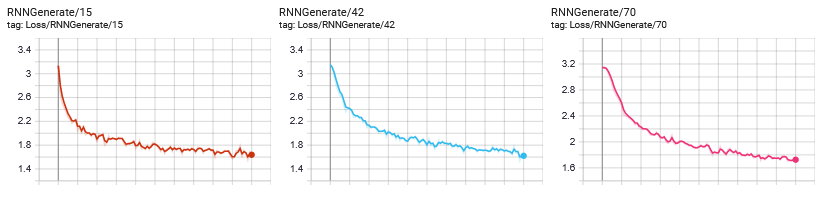

La loss se stabilise autour de 1.5, mais la convergence n'est pas finie ; on aurait pu allonger l'entraînement.  

<span style="color:gray">D'autres expériences plus ou moins concluantes ont été effectuées lors du développement, mais la très grande lenteur associée à la combinaison onehot + couche linéaire ne nous encourage pas à générer encore plus de courbes propres.</span>

## Conclusions

Aucune des tâches de ce Notebook n'a présenté de résultats brillants. 
Une des raisons est le manque de mémoire à long terme, ce à quoi une structure comme une LSTM (Long Short-Term Memory cells) peut remédier. C'est ce que nous étudierons dans le prochain TME.